# Roulette Simulator & Strategy
* Strategy Simulation & Proof Of Concept
* Batch Testing & Robust Stats
* Visualizations

#### Strategies to test
* Flat Bet
* Martingale (Limited & Unlimited)
* Reverse Martingale (Limited & Unlimited)

In [ ]:
# Setup + Imports
import sys
sys.path.append("..")  # Adjust if notebook is in root
import random
import pandas as pd
import statistics

# 🔽 Add this import!
from utils import spin_wheel

In [ ]:
# Import your strategy modules and utilities
from strategies.flat_bet import FlatBetStrategy
from strategies.martingale import MartingaleStrategy
from strategies.reverse_martingale import ReverseMartingaleStrategy
from strategies.martingale_unlimited import MartingaleUnlimitedStrategy
from strategies.reverse_martingale_unlimited import ReverseMartingaleUnlimitedStrategy

from simulator import RouletteSimulator
from analytics.stats import summarize
from config import BET_LIMITS, PAYOUTS

In [3]:
# Helper function to evaluate outcome of a bet
def evaluate_bet(bet_type, outcome):
    from utils import is_red  # only supporting red for now
    if bet_type == "red":
        return is_red(outcome)
    return False

In [4]:
# Core simulation loop
def simulate_strategy(strategy, spins, starting_bankroll=1000):
    sim = RouletteSimulator()
    bankroll = starting_bankroll
    history = []

    for i, outcome in enumerate(spins):
        if bankroll < BET_LIMITS["outside"]["min"]:
            break

        bet = strategy.place_bet(bankroll)
        win = evaluate_bet(bet["type"], outcome)
        payout = bet["amount"] * PAYOUTS[bet["type"]] if win else -bet["amount"]
        bankroll += payout
        strategy.update({"win": win})
        history.append({
            "spin": i + 1,
            "outcome": outcome,
            "win": win,
            "payout": payout,
            "bankroll": bankroll
        })

    return history

In [5]:
# Run all strategies using the same spin sequence
random.seed(42)
spins = [spin_wheel() for _ in range(1000)]

strategies = {
    "Flat Bet": FlatBetStrategy(),
    "Martingale (Limited)": MartingaleStrategy(),
    "Reverse Martingale (Limited)": ReverseMartingaleStrategy(),
    "Martingale (Unlimited)": MartingaleUnlimitedStrategy(),
    "Reverse Martingale (Unlimited)": ReverseMartingaleUnlimitedStrategy()
}

results = {}
for name, strat in strategies.items():
    results[name] = simulate_strategy(strat, spins)

In [ ]:
# Generate summary metrics and comparison table

def strategy_summary(history):
    from analytics.stats import get_max_losing_streak

    bankrolls = [r["bankroll"] for r in history]
    payouts = [r["payout"] for r in history]
    wins = sum(r["win"] for r in history)
    losses = len(history) - wins
    max_drawdown = max((max(bankrolls[:i+1]) - b for i, b in enumerate(bankrolls)), default=0)
    win_rate = (wins / len(history)) * 100 if history else 0
    sharpe = statistics.mean(payouts)/statistics.stdev(payouts) if len(payouts) > 1 and statistics.stdev(payouts) > 0 else 0
    max_losing_streak = get_max_losing_streak(history)

    return {
        "Spins": len(history),
        "Final Bankroll": bankrolls[-1] if bankrolls else 0,
        "P&L": sum(payouts),
        "Win Rate": round(win_rate, 2),
        "Max Drawdown": max_drawdown,
        "Sharpe": round(sharpe, 2),
        "Max Losing Streak": max_losing_streak
    }

summary_df = pd.DataFrame({name: strategy_summary(history) for name, history in results.items()}).T
summary_df.sort_values(by="P&L", ascending=False)

,Spins,Final Bankroll,P&L,Win Rate,Max Drawdown,Sharpe,Max Losing Streak
Martingale (Limited),1000.0,2960.0,1960.0,48.50,2680.0,0.02,8.0
Flat Bet,1000.0,400.0,-600.0,48.50,860.0,-0.03,8.0
Reverse Martingale (Limited),112.0,0.0,-1000.0,49.11,1020.0,-0.10,4.0
Martingale (Unlimited),423.0,0.0,-1000.0,48.94,4860.0,-0.01,8.0
Reverse Martingale (Unlimited),102.0,0.0,-1000.0,50.98,1020.0,-0.10,4.0


In [7]:
# Style output nicely
summary_df.style.background_gradient(cmap='RdYlGn', subset=["P&L", "Sharpe"])\
    .format({"P&L": "${:,.0f}", "Final Bankroll": "${:,.0f}"})

,Spins,Final Bankroll,P&L,Win Rate,Max Drawdown,Sharpe,Max Losing Streak
Flat Bet,1000.000000,$400,$-600,48.500000,860.000000,-0.030000,8.000000
Martingale (Limited),1000.000000,"$2,960","$1,960",48.500000,2680.000000,0.020000,8.000000
Reverse Martingale (Limited),112.000000,$0,"$-1,000",49.110000,1020.000000,-0.100000,4.000000
Martingale (Unlimited),423.000000,$0,"$-1,000",48.940000,4860.000000,-0.010000,8.000000
Reverse Martingale (Unlimited),102.000000,$0,"$-1,000",50.980000,1020.000000,-0.100000,4.000000


## Batch Testing & Robust Stats
* Run 100 simulations per strategy

In [8]:
# Run one full simulation using a random spin sequence
def run_single_simulation(strategy_cls, n_spins=1000, starting_bankroll=1000):
    spins = [spin_wheel() for _ in range(n_spins)]
    strategy = strategy_cls()
    return simulate_strategy(strategy, spins, starting_bankroll)

In [9]:
# Run 100 simulations per strategy
strategy_classes = {
    "Flat Bet": FlatBetStrategy,
    "Martingale (Limited)": MartingaleStrategy,
    "Reverse Martingale (Limited)": ReverseMartingaleStrategy,
    "Martingale (Unlimited)": MartingaleUnlimitedStrategy,
    "Reverse Martingale (Unlimited)": ReverseMartingaleUnlimitedStrategy
}

batch_results = {name: [] for name in strategy_classes}

NUM_RUNS = 100

for name, strat_cls in strategy_classes.items():
    print(f"Running batch for {name}...")
    for _ in range(NUM_RUNS):
        history = run_single_simulation(strat_cls)
        batch_results[name].append(strategy_summary(history))

Running batch for Flat Bet...
Running batch for Martingale (Limited)...
Running batch for Reverse Martingale (Limited)...
Running batch for Martingale (Unlimited)...
Running batch for Reverse Martingale (Unlimited)...


In [10]:
# Convert results to DataFrames
dfs = {name: pd.DataFrame(stats) for name, stats in batch_results.items()}

In [11]:
# Enhanced batch summary: include mean, % profitable, % bankrupt, medians
summary_stats = []

for name, df in dfs.items():
    avg_stats = df.mean()
    total_runs = len(df)
    profitable_runs = (df["P&L"] > 0).sum()
    bankruptcies = (df["Final Bankroll"] <= 0).sum()
    breakeven_or_better = (df["Final Bankroll"] >= 1000).sum()
    
    avg_stats["% Profitable Runs"] = round(profitable_runs / total_runs * 100, 2)
    avg_stats["% Bankruptcies"] = round(bankruptcies / total_runs * 100, 2)
    avg_stats["Median Spins"] = df["Spins"].median()
    avg_stats["Median Final Bankroll"] = df["Final Bankroll"].median()
    avg_stats["Strategy"] = name
    
    summary_stats.append(avg_stats)

summary_df = pd.DataFrame(summary_stats).set_index("Strategy")
summary_df = summary_df[
    [
        "Spins", "Final Bankroll", "P&L", "Win Rate", 
        "Max Drawdown", "Sharpe",
        "% Profitable Runs", "% Bankruptcies",
        "Median Spins", "Median Final Bankroll"
    ]
]
summary_df.round(2).sort_values(by="P&L", ascending=False)


,Spins,Final Bankroll,P&L,Win Rate,Max Drawdown,Sharpe,% Profitable Runs,% Bankruptcies,Median Spins,Median Final Bankroll
Strategy,,,,,,,,,,
Martingale (Unlimited),170.46,274.6,-725.4,42.17,2190.2,-0.16,3.0,97.0,85.5,0.0
Flat Bet,741.92,164.8,-835.2,46.38,1058.8,-0.07,3.0,68.0,790.0,0.0
Martingale (Limited),188.21,164.0,-836.0,41.75,1796.6,-0.20,4.0,96.0,65.0,0.0
Reverse Martingale (Limited),255.93,57.0,-943.0,46.46,1872.6,-0.09,1.0,95.0,126.5,0.0
Reverse Martingale (Unlimited),94.67,0.0,-1000.0,46.62,2574.0,-0.11,0.0,100.0,95.0,0.0


In [12]:
# Export batch results for external use
for name, df in dfs.items():
    df.to_csv(f"results_batch_{name.replace(' ', '_')}.csv", index=False)

summary_df.to_csv("results_summary_batch.csv")


## Visualizations
* Bankroll over time
* Histogram of bankrolls
* Streaks, drawdowns, etc

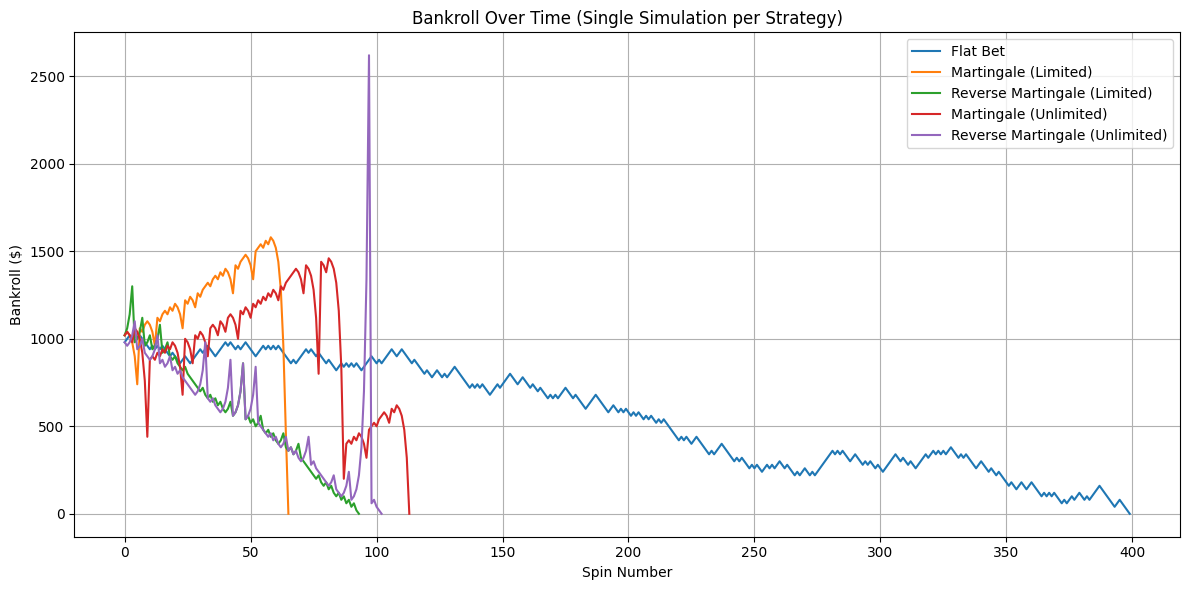

In [13]:
# Plot bankroll over time for a sample run per strategy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for name, strat_cls in strategy_classes.items():
    sample_spins = [spin_wheel() for _ in range(1000)]
    strat = strat_cls()
    history = simulate_strategy(strat, sample_spins)
    bankrolls = [r["bankroll"] for r in history]
    plt.plot(bankrolls, label=name)

plt.title("Bankroll Over Time (Single Simulation per Strategy)")
plt.xlabel("Spin Number")
plt.ylabel("Bankroll ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

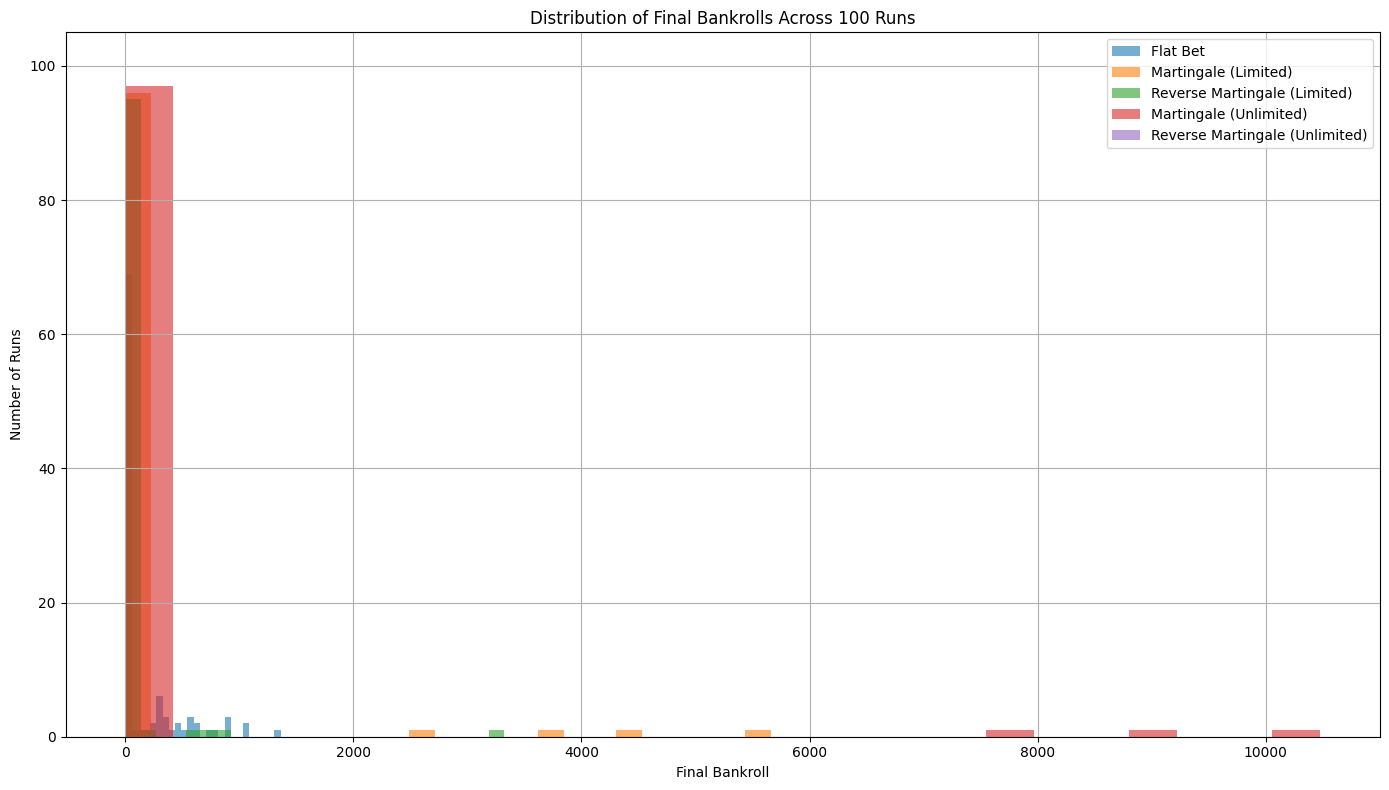

In [14]:
# Histogram of final bankrolls across all runs for each strategy
plt.figure(figsize=(14, 8))

for name, df in dfs.items():
    plt.hist(df["Final Bankroll"], bins=25, alpha=0.6, label=name)

plt.title("Distribution of Final Bankrolls Across 100 Runs")
plt.xlabel("Final Bankroll")
plt.ylabel("Number of Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\JR\AppData\Local\Temp\ipykernel_3316\3680893969.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(drawdown_data, labels=dfs.keys(), showfliers=True)


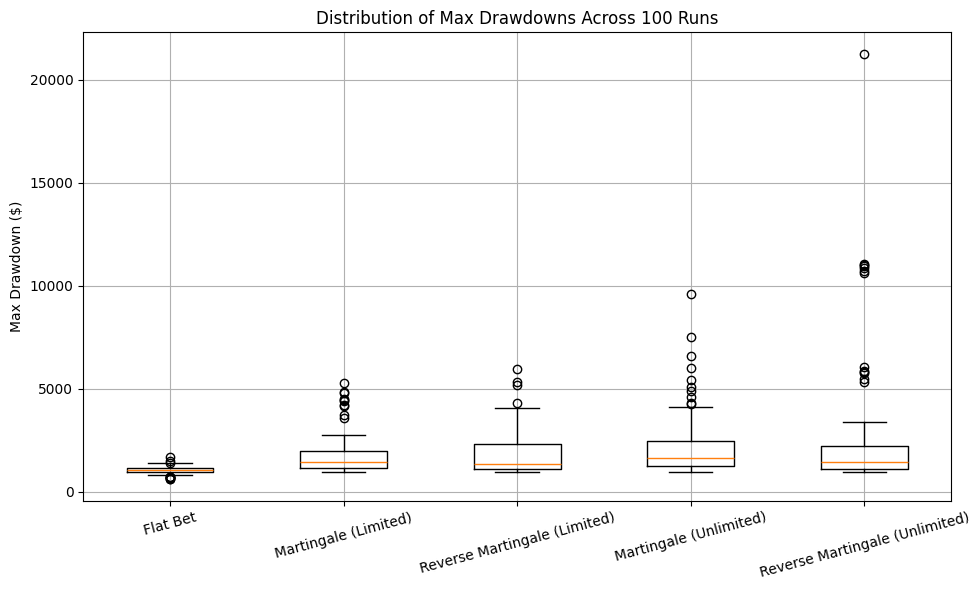

In [18]:
# Boxplot of max drawdowns by strategy
plt.figure(figsize=(10, 6))
drawdown_data = [df["Max Drawdown"] for df in dfs.values()]
plt.boxplot(drawdown_data, labels=dfs.keys(), showfliers=True)
plt.title("Distribution of Max Drawdowns Across 100 Runs")
plt.ylabel("Max Drawdown ($)")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()

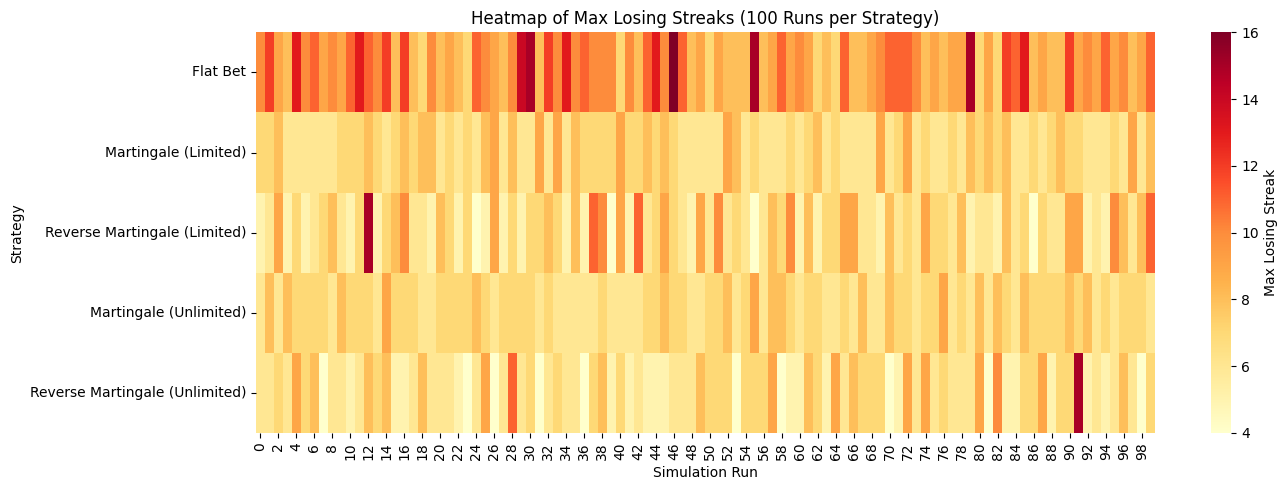

In [16]:
# Heatmap of longest losing streaks
import seaborn as sns

# Create a matrix: strategy (rows) x run (columns)
heatmap_data = pd.DataFrame({
    name: [s["Max Losing Streak"] for s in stats] 
    for name, stats in batch_results.items()
}).T

plt.figure(figsize=(14, 5))
sns.heatmap(heatmap_data, cmap="YlOrRd", cbar_kws={'label': 'Max Losing Streak'})
plt.title("Heatmap of Max Losing Streaks (100 Runs per Strategy)")
plt.xlabel("Simulation Run")
plt.ylabel("Strategy")
plt.tight_layout()
plt.show()

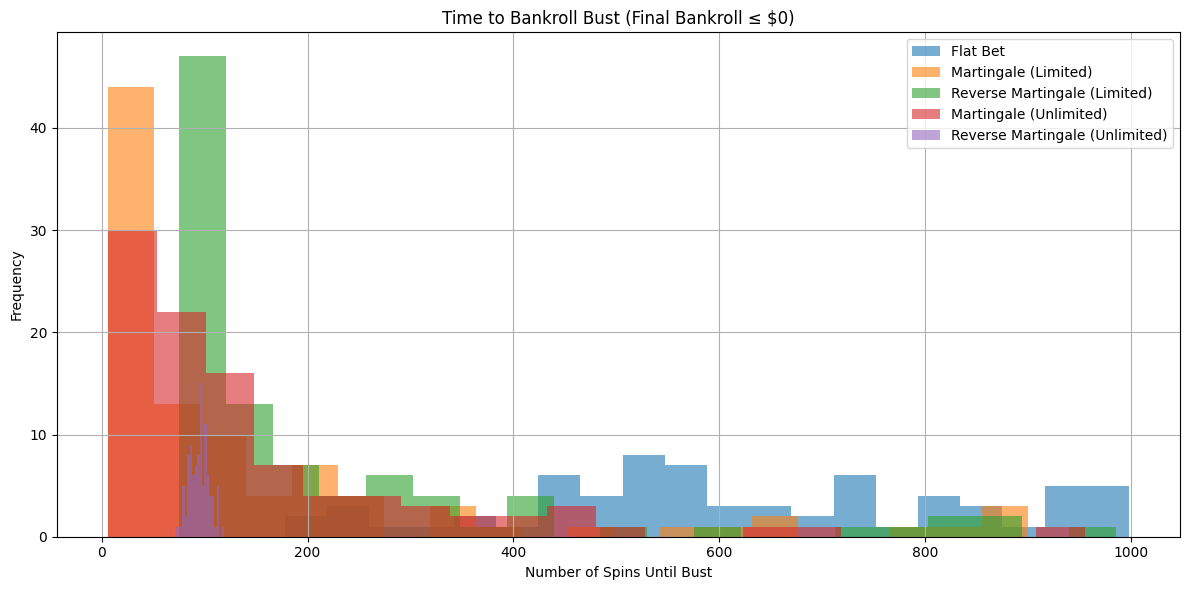

In [17]:
# Time to bust distribution
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    bust_times = df[df["Final Bankroll"] <= 0]["Spins"]
    if not bust_times.empty:
        plt.hist(bust_times, bins=20, alpha=0.6, label=name)

plt.title("Time to Bankroll Bust (Final Bankroll ≤ $0)")
plt.xlabel("Number of Spins Until Bust")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()